# Approach 1a: Basic frame differencing
For this most basic approach, we compare each motion image $M$ to the closest lapse image $L$ and take the
1. mean absolute pixel-wise difference $ \frac{1}{xy} \sum_{x,y} | M_{x,y} - L_{x,y} | $
2. mean squared pixel-wise difference $ \frac{1}{xy} \sum_{x,y} (M_{x,y} - L_{x,y})^2 $
M and L are both grayscale.

**Reasoning:** We assume that anomalous images highly differ from the closest lapse image in a significant amount of pixels while normal images only have low pixel differences.

### Suspected problems
- **Noise** (we scale the images down for performance reasons which also reduces noise a bit)
- **Small object movements** that are not of interest (such as leaves, dust particles, etc.)
- Very sensitive to **camera movement** (which seems to happen a lot in the dataset)
- Since we eliminate the **color information**, a deer might look very much like a forest.

## Setup

In [1]:
%load_ext autoreload
%autoreload 2

from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import numpy as np
from skimage.color import rgb2gray
from tqdm import tqdm
import warnings

from py.PlotUtils import plot_roc_curve, get_percentiles
from py.Dataset import Dataset
from py.Session import MotionImage
from py.ImageUtils import display_images, is_daytime, save_image
from py.Labels import LABELS
from py.ImageClassifier import AbstractImageClassifier

DIR = './ResizedSessions_NoBackup' # dataset directory

ds = Dataset(DIR)
session = ds.create_session("marten_01")

Found 3 sessions
Session 'Marten_01' at folder: ./ResizedSessions_NoBackup/VIELAAS_Spring_Session01-VIELAAS_Marten_01
Loaded scans.


## Experiment 1: Basic classifier
The proposed classifier computes the following features
- mean of absolute pixel-wise difference _absmean_
- variance of absolute pixel-wise difference _absvar_
- mean of squared pixel-wise difference _sqmean_
- var of squared pixel-wise difference _sqvar_

In [14]:
def normalize(comp_arr, motion_arr):
    # normalize comp_arr and transform motion_arr identically
    mean, std = np.mean(comp_arr), np.std(comp_arr)
    motion_arr = (motion_arr - mean) / std
    comp_arr = (comp_arr - mean) / std
    return comp_arr, motion_arr

def normalize_img(img):
    return (img - np.mean(img)) / np.std(img)

class FrameDiffClassifier(AbstractImageClassifier):
    def evaluate(self, motion_img: MotionImage, display=False, save=False):
        before_img, after_img, rel = motion_img.get_closest_lapse_images()
        comp_img = before_img if rel <= 0.5 else after_img
        motion_arr = motion_img.read(gray=False)
        comp_arr = comp_img.read(gray=False)
        motion_daytime = is_daytime(motion_arr)

        # don't compare daytime with nighttime images
        if motion_daytime != is_daytime(comp_arr):
            # choose the other closest lapse image
            comp_img = after_img if rel <= 0.5 else before_img
            comp_arr = comp_img.read(gray=False)
            assert motion_daytime == is_daytime(comp_arr)
            # if this assertion fails, a motion image was captured at daytime between two nighttime lapse images or the other way around

        # convert to gray
        motion_arr = rgb2gray(motion_arr)
        comp_arr = rgb2gray(comp_arr)

        # comp_arr, motion_arr = normalize(comp_arr, motion_arr)
        comp_arr, motion_arr = normalize_img(comp_arr), normalize_img(motion_arr)

        absdiff = abs(motion_arr - comp_arr)
        sqdiff = (motion_arr - comp_arr) ** 2
        absmean = np.average(absdiff)
        absvar = np.var(absdiff)
        sqmean = np.average(sqdiff)
        sqvar = np.var(sqdiff)

        if display:
            # display_images([motion_arr, comp_arr, absdiff, sqdiff], ["Motion image", "Closest lapse image", f"abs mean = {absmean}, std = {absstd}", f"sq mean = {sqmean}, std = {sqstd}"], cmap="gray")
            display_images([motion_arr, comp_arr, sqdiff], [f"Motion {motion_img.date}", f"Closest Lapse {comp_img.date}", f"Squared pixel-wise difference (mean={sqmean:.3f}, var={sqvar:.3f})"], row_size=3, cmap="gray")
        if save:
            save_image(motion_arr, "imgs/approach1a_motion.pdf", None, cmap="gray")
            save_image(comp_arr, "imgs/approach1a_lapse.pdf", None, cmap="gray")
            save_image(sqdiff, "imgs/approach1a_sqdiff.pdf", None, cmap="gray")

        return absmean, absvar, sqmean, sqvar

### Visualize difference image

/home/kleinsteuber/vscode/py/Session.py:278: UserWarning: There are multiple lapse images for date 2021-04-24 11:00:00! Choosing the first one.
  warn(f"There are multiple lapse images for date {previous_date}! Choosing the first one.")
/home/kleinsteuber/vscode/py/Session.py:280: UserWarning: There are multiple lapse images for date 2021-04-24 12:00:00! Choosing the first one.
  warn(f"There are multiple lapse images for date {next_date}! Choosing the first one.")


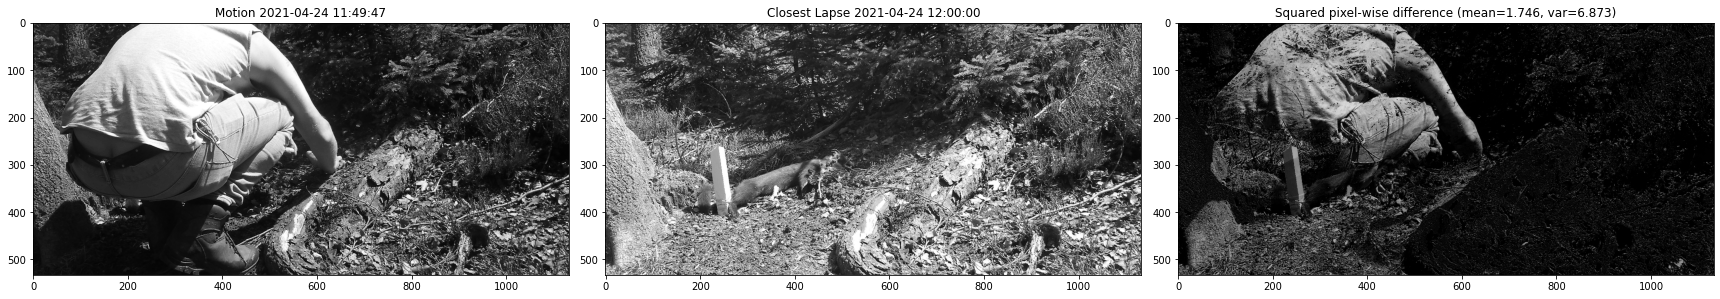

In [16]:
img = session.get_random_motion_image() # session.get_motion_image_from_filename("Beaver_01_00509.jpg")
classifier = FrameDiffClassifier()
output = classifier.evaluate(img, display=True, save=False)

The anomalous object is usually clearly visible in the difference image but there are still a lot of unwanted artefacts around it (possibly because of small object movement and noise).

### Evaluate on all Motion images

In [17]:
def generate_test_scores(classifier):
    normal_scores = []
    anomalous_scores = []

    for img in tqdm(list(session.generate_motion_images())):
        img_nr = int(img.filename[-9:-4])
        if img_nr > LABELS[session.name]["max"] or img_nr in LABELS[session.name]["not_annotated"]:
            continue
        score = classifier.evaluate(img)
        if img_nr in LABELS[session.name]["normal"]:
            normal_scores.append(score)
        else:
            anomalous_scores.append(score)
    return normal_scores, anomalous_scores

In [18]:
classifier = FrameDiffClassifier()
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    normal_scores, anomalous_scores = generate_test_scores(classifier)

100%|██████████| 3105/3105 [04:24<00:00, 11.75it/s]


### Visualize data points
By plotting the scores produced by frame differencing, we can see if the normal and anomalous classes are linearly separable.

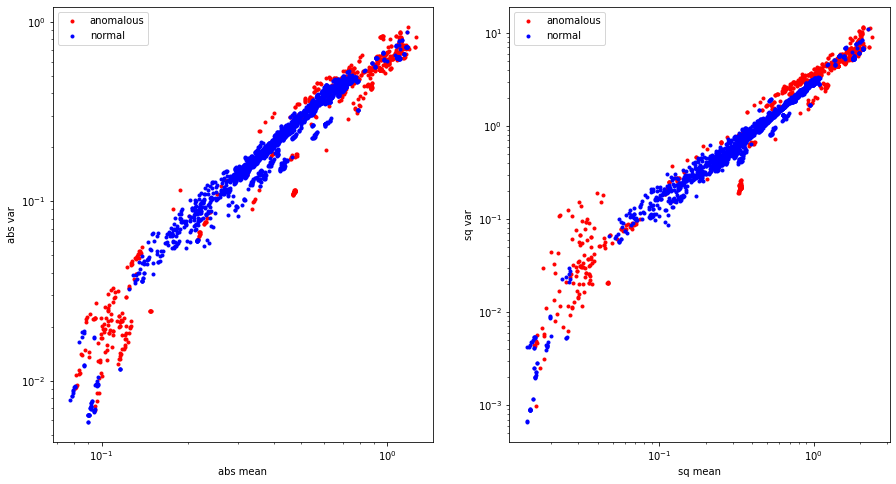

In [19]:
def plot(i1, i2, normal_scores, anomalous_scores, scale="log"):
    titles = ["abs mean", "abs var", "sq mean", "sq var"]
    plt.scatter([ar[i1] for ar in anomalous_scores], [ar[i2] for ar in anomalous_scores], color="red", label="anomalous", marker=".")
    plt.scatter([ar[i1] for ar in normal_scores], [ar[i2] for ar in normal_scores], color="blue", label="normal", marker=".")
    plt.xlabel(titles[i1])
    plt.ylabel(titles[i2])
    plt.xscale(scale)
    plt.yscale(scale)
    plt.legend()
    
plt.figure(figsize=(15, 8))
plt.subplot(1, 2, 1)
plot(0, 1, normal_scores, anomalous_scores)
plt.subplot(1, 2, 2)
plot(2, 3, normal_scores, anomalous_scores)
plt.show()

Unfortunately, there is not a clear separating line between the two classes but normal samples tend to have lower variance and mean values than anomalies.

### Scoring (AUC and elimination rates)

In [20]:
y_anom = np.array(anomalous_scores)
assert y_anom.shape[1] == 4

y_norm = np.array(normal_scores)
assert y_norm.shape[1] == 4

X = np.concatenate([y_norm, y_anom])
print(X.shape)
y = np.concatenate([-np.ones((y_norm.shape[0])), np.ones((y_anom.shape[0]))])
print(y.shape)

(3105, 4)
(3105,)


absmean auc=0.6355777888310892
0.9 percentile : TPR = 0.9071, FPR = 0.9768 <-> TNR = 0.0232 @ thresh 0.10961586920510108
0.95 percentile : TPR = 0.9604, FPR = 0.9768 <-> TNR = 0.0232 @ thresh 0.09733281438072432
0.99 percentile : TPR = 0.9918, FPR = 0.9958 <-> TNR = 0.0042 @ thresh 0.0835324211615366
absvar auc=0.6136761126424554
0.9 percentile : TPR = 0.9003, FPR = 0.9756 <-> TNR = 0.0244 @ thresh 0.021398314256101496
0.95 percentile : TPR = 0.9768, FPR = 0.9785 <-> TNR = 0.0215 @ thresh 0.01243139288576224
0.99 percentile : TPR = 0.9904, FPR = 0.9853 <-> TNR = 0.0147 @ thresh 0.00925403959223749
sqmean auc=0.6279026456561636
0.9 percentile : TPR = 0.9208, FPR = 0.9756 <-> TNR = 0.0244 @ thresh 0.030851647496162603
0.95 percentile : TPR = 0.9590, FPR = 0.9756 <-> TNR = 0.0244 @ thresh 0.0264403832629429
0.99 percentile : TPR = 0.9904, FPR = 0.9848 <-> TNR = 0.0152 @ thresh 0.016927961736901812
sqvar auc=0.636314100571318
0.9 percentile : TPR = 0.9221, FPR = 0.9756 <-> TNR = 0.0244 @ t

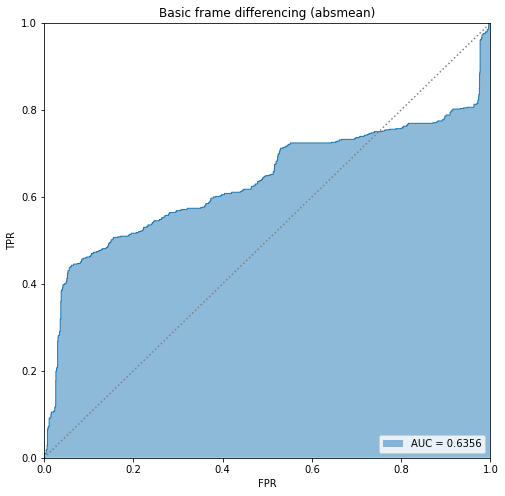

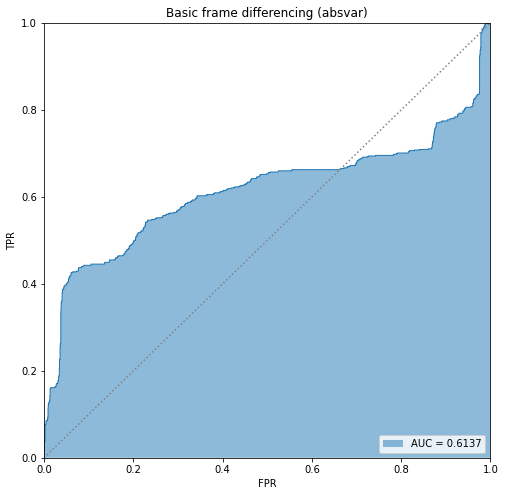

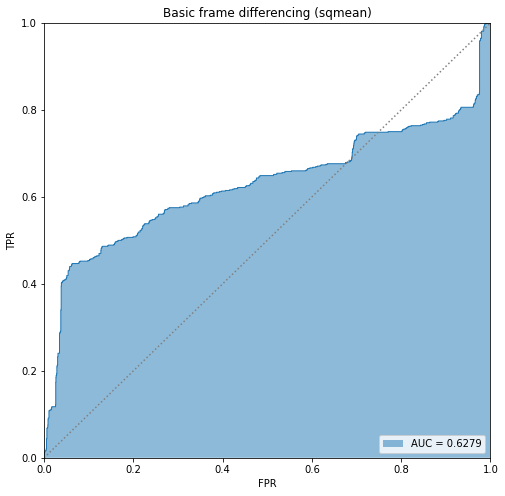

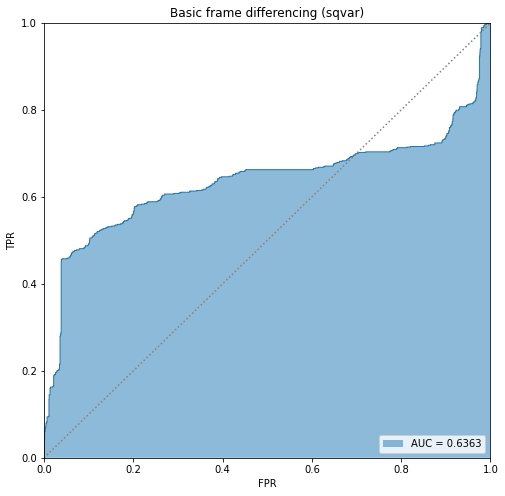

In [21]:
vals = ["absmean", "absvar", "sqmean", "sqvar"]
for i in range(4):
    fpr, tpr, thresholds, auc_score = plot_roc_curve(y, X[:,i], f"Basic frame differencing ({vals[i]})", savefile=f"plots/approach1a/roc_curves/{session.name}_{vals[i]}", show=False)
    print(f"{vals[i]} auc={auc_score}")
    get_percentiles(fpr, tpr, thresholds, percentiles=[0.9, 0.95, 0.99])

## Experiment 2: Add a Gaussian filter

In [22]:
from py.ImageClassifier import AbstractImageClassifier
from scipy import ndimage

class GaussianFrameDiffClassifier(AbstractImageClassifier):
    def __init__(self, sigma: int):
        self.sigma = sigma
    
    def evaluate(self, motion_img: MotionImage, display=False, save=False):
        before_img, after_img, rel = motion_img.get_closest_lapse_images()
        comp_img = before_img if rel <= 0.5 else after_img
        motion_arr = motion_img.read(gray=False)
        comp_arr = comp_img.read(gray=False)
        motion_daytime = is_daytime(motion_arr)

        # don't compare daytime with nighttime images
        if motion_daytime != is_daytime(comp_arr):
            # choose the other closest lapse image
            comp_img = after_img if rel <= 0.5 else before_img
            comp_arr = comp_img.read(gray=False)
            assert motion_daytime == is_daytime(comp_arr)
            # if this assertion fails, a motion image was captured at daytime between two nighttime lapse images or the other way around

        # convert to gray
        motion_arr = rgb2gray(motion_arr)
        comp_arr = rgb2gray(comp_arr)

        comp_arr, motion_arr = normalize_img(comp_arr), normalize_img(motion_arr)

        motion_arrg = ndimage.gaussian_filter(motion_arr, sigma=self.sigma)
        comp_arrg = ndimage.gaussian_filter(comp_arr, sigma=self.sigma)

        absdiff = abs(motion_arrg - comp_arrg)
        sqdiff = (motion_arrg - comp_arrg) ** 2
        absmean = np.average(absdiff)
        absvar = np.var(absdiff)
        sqmean = np.average(sqdiff)
        sqvar = np.var(sqdiff)

        if display:
            #display_images([motion_arr, comp_arr, absdiff, sqdiff], ["Motion image", "Closest lapse image", f"abs mean = {absmean}, var = {absvar}", f"sq mean = {sqmean}, var = {sqvar}"], cmap="gray")
            display_images([motion_arrg, comp_arrg, sqdiff], [f"Motion {motion_img.date} (sigma={self.sigma})", f"Closest Lapse {comp_img.date} (sigma={self.sigma})", f"Squared pixel-wise difference (mean={sqmean:.3f}, var={sqvar:.3f})"], row_size=3, cmap="gray")
        if save:
            save_image(motion_arrg, f"imgs/approach1a_sigma{self.sigma}_motion.pdf", None, cmap="gray")
            save_image(comp_arrg, f"imgs/approach1a_sigma{self.sigma}_lapse.pdf", None, cmap="gray")
            save_image(sqdiff, f"imgs/approach1a_sigma{self.sigma}_sqdiff.pdf", None, cmap="gray")

        return absmean, absvar, sqmean, sqvar

### Visualize difference image

/home/kleinsteuber/vscode/py/Session.py:278: UserWarning: There are multiple lapse images for date 2021-04-27 13:00:00! Choosing the first one.
  warn(f"There are multiple lapse images for date {previous_date}! Choosing the first one.")
/home/kleinsteuber/vscode/py/Session.py:280: UserWarning: There are multiple lapse images for date 2021-04-27 14:00:00! Choosing the first one.
  warn(f"There are multiple lapse images for date {next_date}! Choosing the first one.")


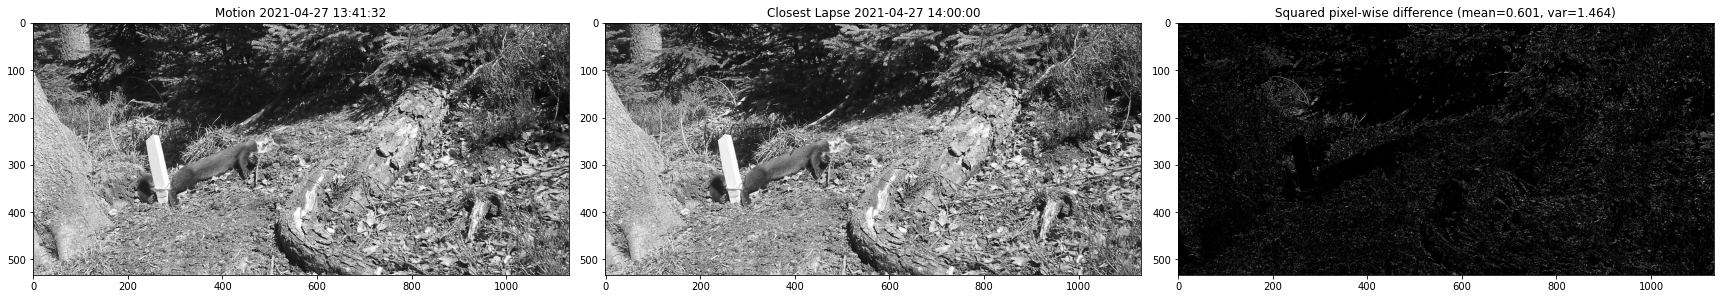

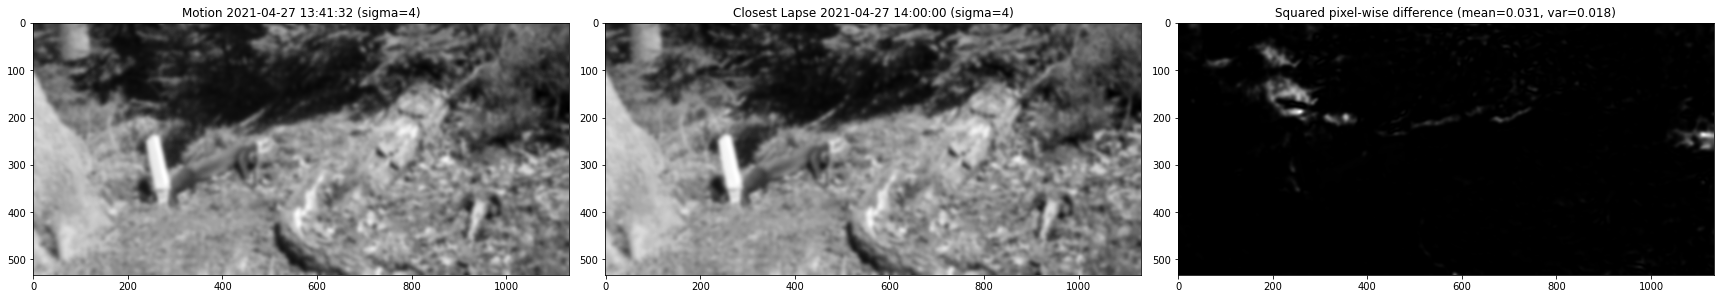

In [23]:
img = session.get_random_motion_image(day_only=True)
# img = session.get_motion_image_from_filename("Beaver_01_00025.jpg")
classifier = FrameDiffClassifier()
out = classifier.evaluate(img, display=True, save=False)
classifier2 = GaussianFrameDiffClassifier(sigma=4)
out = classifier2.evaluate(img, display=True, save=False)

### Evaluate on all Motion images

In [24]:
classifier = GaussianFrameDiffClassifier(sigma=6)
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    normal_scores_g, anomalous_scores_g = generate_test_scores(classifier)

100%|██████████| 3105/3105 [07:51<00:00,  6.58it/s]


### Visualize data points

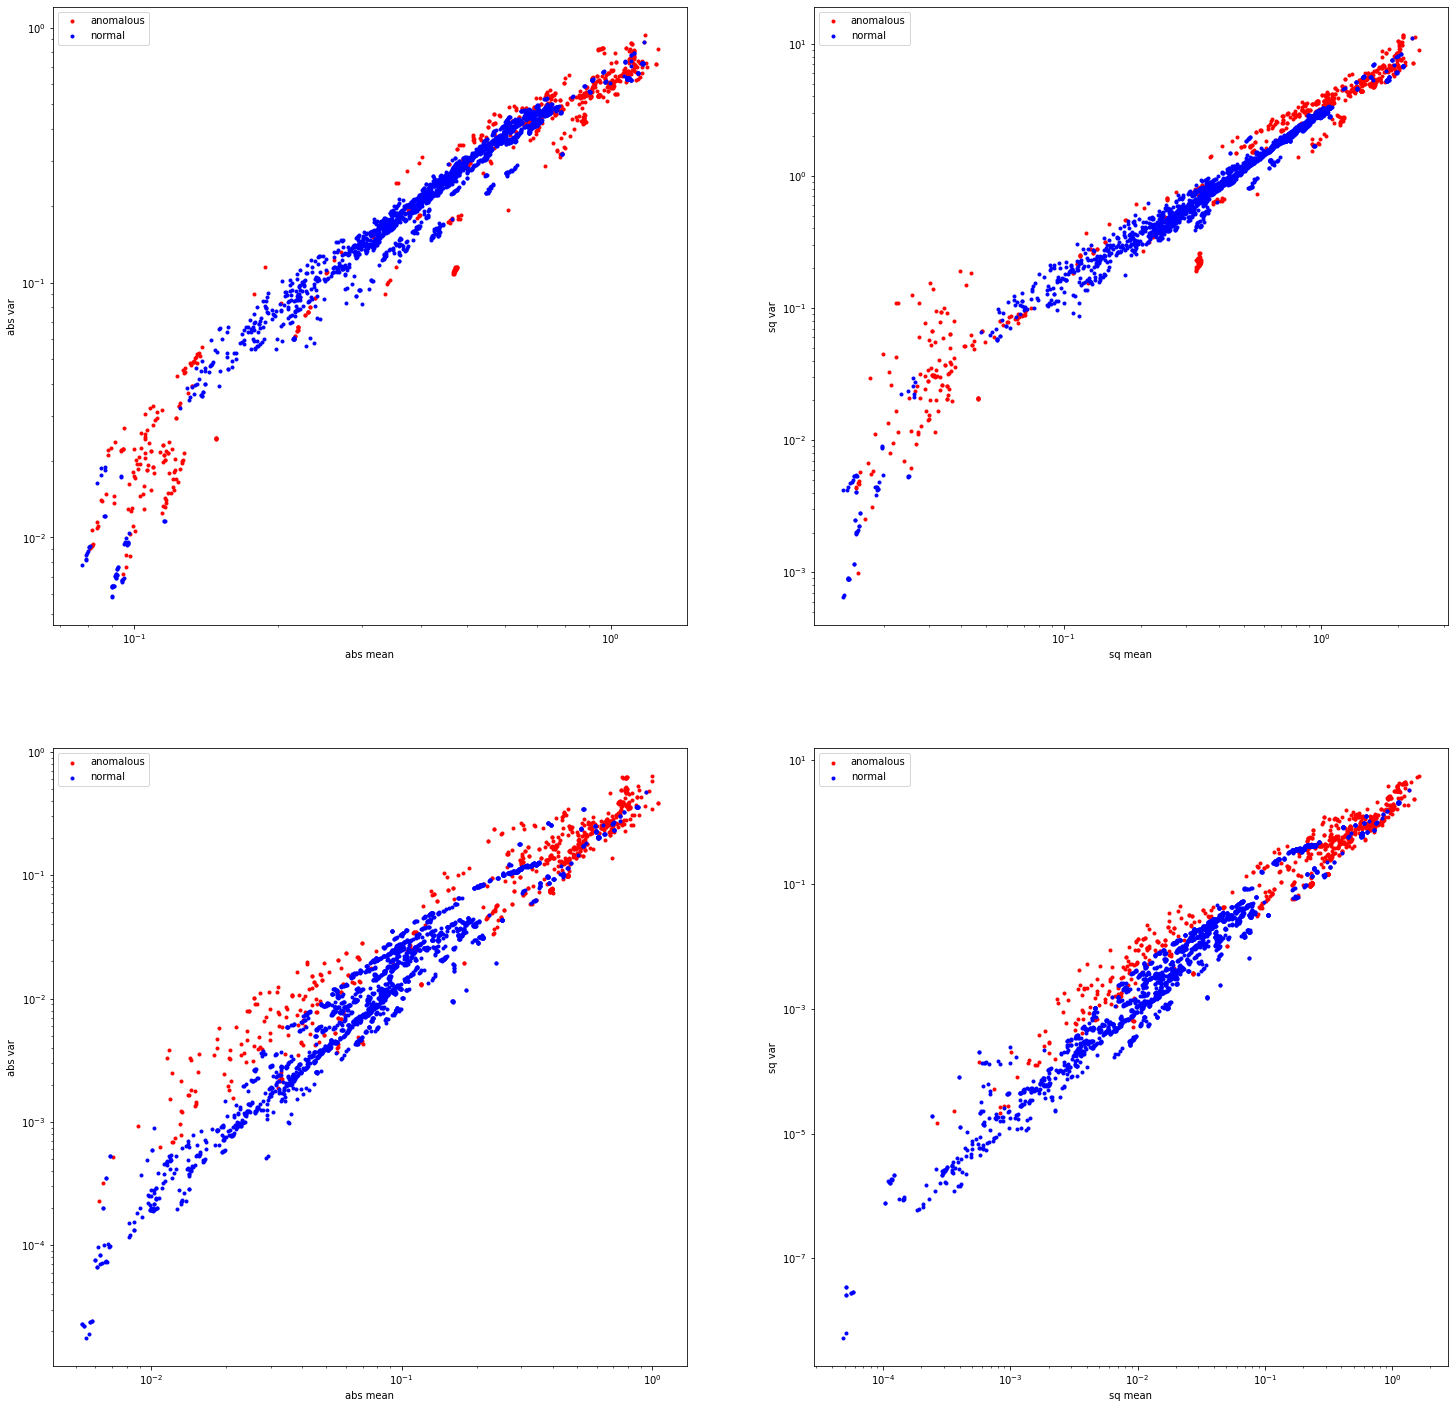

In [25]:
scale = "log"
plt.figure(figsize=(25, 25))
plt.subplot(2, 2, 1)
plot(0, 1, normal_scores, anomalous_scores, scale=scale)
plt.subplot(2, 2, 2)
plot(2, 3, normal_scores, anomalous_scores, scale=scale)
plt.subplot(2, 2, 3)
plot(0, 1, normal_scores_g, anomalous_scores_g, scale=scale)
plt.subplot(2, 2, 4)
plot(2, 3, normal_scores_g, anomalous_scores_g, scale=scale)
plt.show()

(3105, 4)
(3105,)
absmean sigma=6 auc=0.7531850232234679
0.9 percentile : TPR = 0.9016, FPR = 0.8740 <-> TNR = 0.1260 @ thresh 0.032425076185018734
0.95 percentile : TPR = 0.9508, FPR = 0.9288 <-> TNR = 0.0712 @ thresh 0.02073934352418058
0.98 percentile : TPR = 0.9809, FPR = 0.9587 <-> TNR = 0.0413 @ thresh 0.013175973601756659
0.99 percentile : TPR = 0.9904, FPR = 0.9633 <-> TNR = 0.0367 @ thresh 0.011898081155165488
absvar sigma=6 auc=0.7790002625161481
0.9 percentile : TPR = 0.9003, FPR = 0.7577 <-> TNR = 0.2423 @ thresh 0.005026038003266494
0.95 percentile : TPR = 0.9508, FPR = 0.8213 <-> TNR = 0.1787 @ thresh 0.0032058668136211088
0.98 percentile : TPR = 0.9809, FPR = 0.8972 <-> TNR = 0.1028 @ thresh 0.0014498453031559072
0.99 percentile : TPR = 0.9904, FPR = 0.9351 <-> TNR = 0.0649 @ thresh 0.0007798755273484217
sqmean sigma=6 auc=0.7759122436149855
0.9 percentile : TPR = 0.9003, FPR = 0.7813 <-> TNR = 0.2187 @ thresh 0.007083786384728686
0.95 percentile : TPR = 0.9508, FPR = 0.

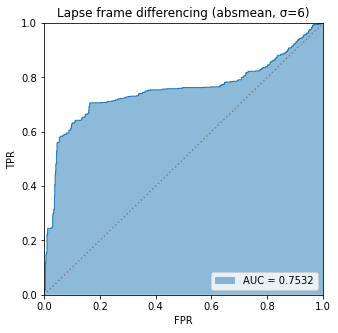

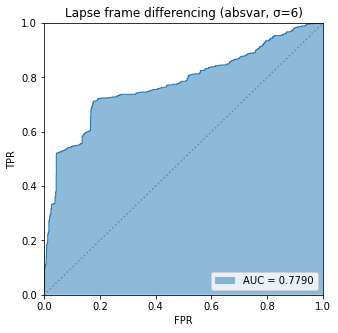

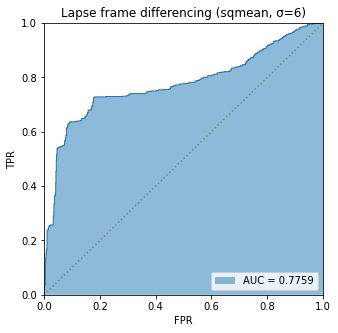

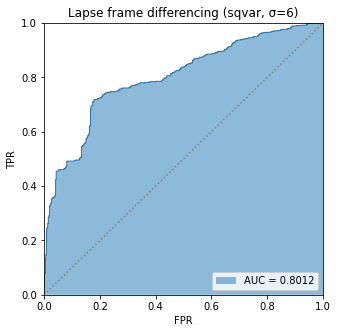

In [26]:
# Display ROC Curve
sigma = 6
y_anom = np.array(anomalous_scores_g)
assert y_anom.shape[1] == 4

y_norm = np.array(normal_scores_g)
assert y_norm.shape[1] == 4

X = np.concatenate([y_norm, y_anom])
print(X.shape)
y = np.concatenate([-np.ones((y_norm.shape[0])), np.ones((y_anom.shape[0]))])
print(y.shape)

vals = ["absmean", "absvar", "sqmean", "sqvar"]
for i in range(4):
    fpr, tpr, thresholds, auc_score = plot_roc_curve(y, X[:,i], f"Lapse frame differencing ({vals[i]}, σ={sigma})", savefile=f"plots/approach1a/roc_curves/{session.name}_{vals[i]}_sigma{sigma}", show=False, figsize=(5,5))
    print(f"{vals[i]} sigma={sigma} auc={auc_score}")
    get_percentiles(fpr, tpr, thresholds)